<a href="https://colab.research.google.com/github/Jegge2003/TimeSeries/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING THE NEEDED LIBRARIES

In [6]:
#Importing libraries with their right aliases.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
  #Uploading file from local to google colab
  from google.colab import files
  files.upload()

In [9]:
#Setting color pattern and color style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

EXPLORATORY DATA ANALYSIS

In [10]:
#Reading file as pandas dataframe and setting Datetime column as index
df = pd.read_csv('/content/AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

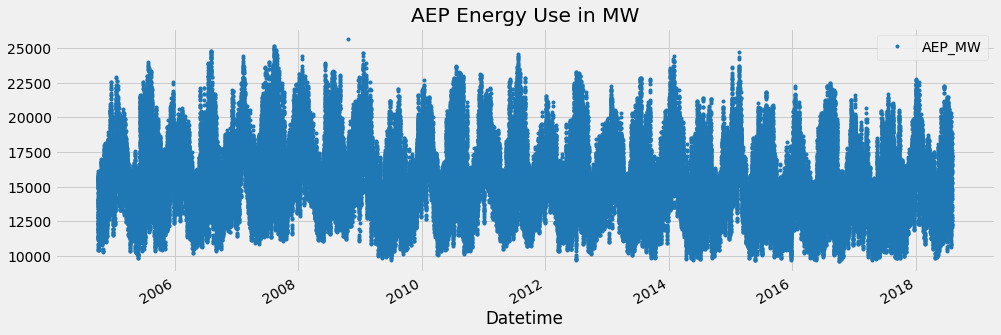

In [11]:
#Plotting the dataset
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AEP Energy Use in MW')
plt.show()

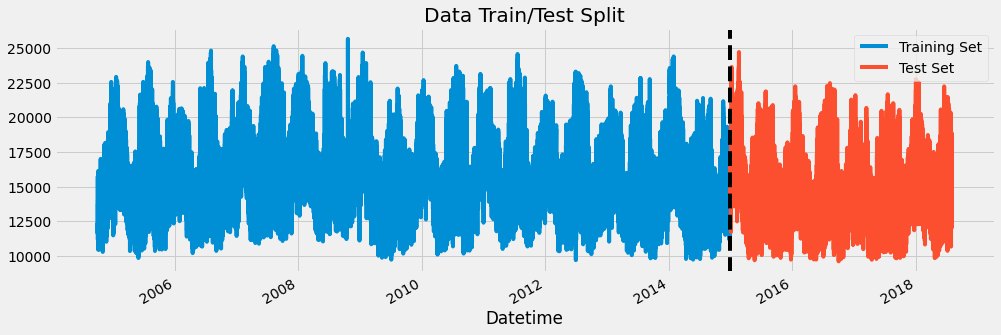

In [12]:
#splitting data into train set and test set
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

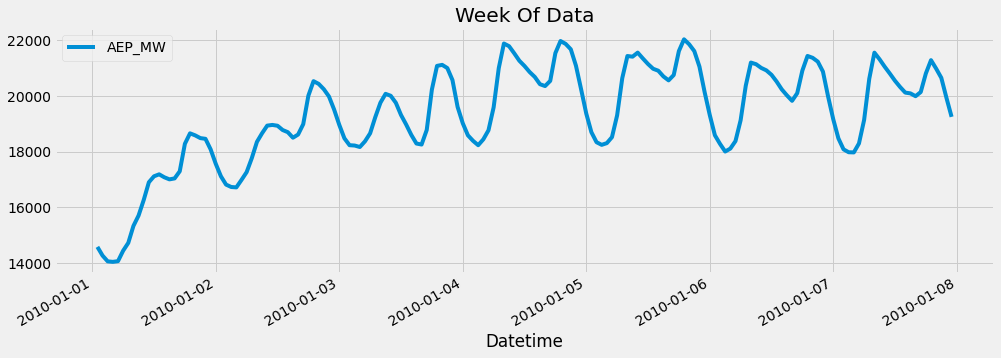

In [14]:
#Visualizing one week data from 1st January 2010 to 8th January, 2010
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

FEATURE ENGINEERING

In [15]:
#Feature Engineering
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [16]:
#Showing the first 5 rows of our engineered dataset
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53


In [18]:
#Splitting datasets in X and y
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

CREATING MODEL

In [19]:
#Creating the model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15793.2	validation_1-rmse:14861.3
[100]	validation_0-rmse:6033.9	validation_1-rmse:5144.93
[200]	validation_0-rmse:2702.82	validation_1-rmse:2158.5
[300]	validation_0-rmse:1754.97	validation_1-rmse:1666.22
[400]	validation_0-rmse:1516.42	validation_1-rmse:1658.11
[500]	validation_0-rmse:1430.96	validation_1-rmse:1665.27
[600]	validation_0-rmse:1388.51	validation_1-rmse:1666.47
[700]	validation_0-rmse:1358.13	validation_1-rmse:1667.29
[800]	validation_0-rmse:1334.84	validation_1-rmse:1668.95
[900]	validation_0-rmse:1318.92	validation_1-rmse:1660.61
[999]	validation_0-rmse:1304.95	validation_1-rmse:1656.82


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

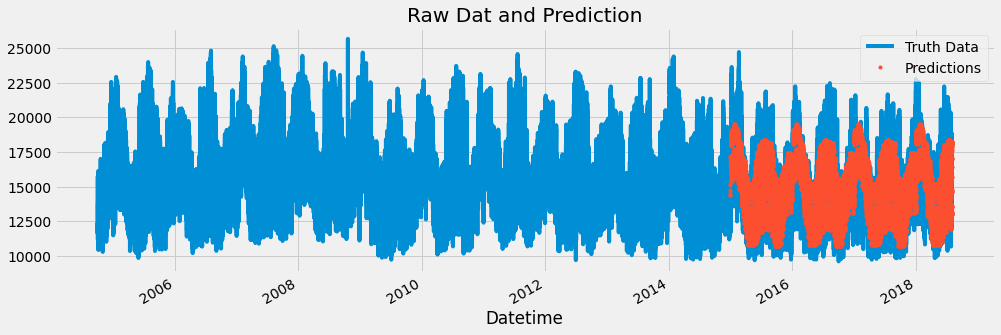

In [23]:
#Plot showing predicted values and raw values
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [25]:
#Scoring the model
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1656.83
